# Long Short-Term Memory (LSTM)

## Introduction

**LSTM (Long Short-Term Memory)** constitutes a specialized architecture of recurrent
neural networks designed specifically to address one of the most significant limitations
of conventional RNNs: the inability to effectively maintain and use information across
extensive sequences. This problem, known as the vanishing gradient problem in long-term
dependencies, prevents simple RNNs from capturing relationships between distant elements
in a sequence.

While traditional RNNs can process sequential information and maintain an internal state,
their memory capacity is limited in practice. Information tends to degrade exponentially
as it propagates through multiple time steps, making it difficult to learn patterns that
require remembering events that occurred many steps back. LSTMs solve this problem
through a more sophisticated architecture that incorporates explicit control mechanisms
over what information should be retained, updated, or discarded at each time step.

## The problem of long-term dependencies

THE MEMORY PROBLEM IN RNNs

EXAMPLE 1: Short-Term Dependency (RNN works well)
------------------------------------------------------------
Text: The sky is ___
To predict the missing word, we only need to
remember 'sky' (recent word)
✓ Simple RNN: WORKS WELL


EXAMPLE 2: Long-Term Dependency (RNN fails)
------------------------------------------------------------
Text: 
    I was born in France. I spent my childhood playing in the
    lavender fields. Then I traveled the world for 20 years. Now
    I live in Spain, but I speak fluent French because I grew up in ___
    

To predict the missing word ('France'),
we need to remember information from the BEGINNING of the text
✗ Simple RNN: FAILS (forgets old information)
✓ LSTM: WORKS (maintains long-term memory)


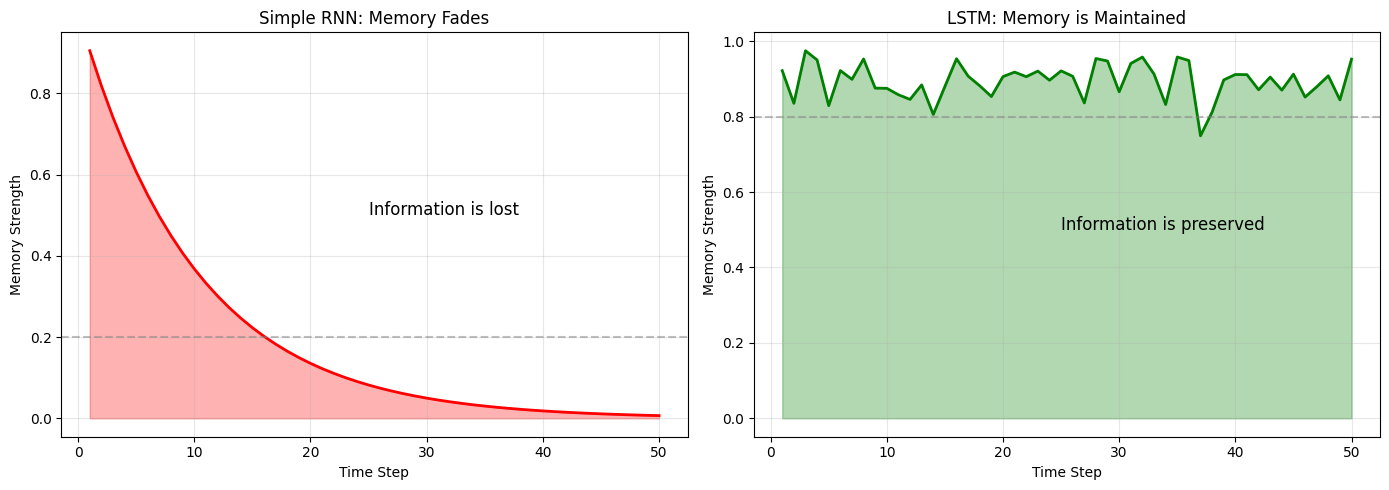


CONCLUSION: LSTM maintains information for much longer


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


def demonstrate_memory_problem():
    """
    Demonstrates why we need LSTMs instead of simple RNNs.
    """
    print("=" * 60)
    print("THE MEMORY PROBLEM IN RNNs")
    print("=" * 60)

    print("\nEXAMPLE 1: Short-Term Dependency (RNN works well)")
    print("-" * 60)
    short_text = "The sky is ___"
    print(f"Text: {short_text}")
    print("To predict the missing word, we only need to")
    print("remember 'sky' (recent word)")
    print("✓ Simple RNN: WORKS WELL")

    print("\n\nEXAMPLE 2: Long-Term Dependency (RNN fails)")
    print("-" * 60)
    long_text = """
    I was born in France. I spent my childhood playing in the
    lavender fields. Then I traveled the world for 20 years. Now
    I live in Spain, but I speak fluent French because I grew up in ___
    """
    print(f"Text: {long_text}")
    print("\nTo predict the missing word ('France'),")
    print("we need to remember information from the BEGINNING of the text")
    print("✗ Simple RNN: FAILS (forgets old information)")
    print("✓ LSTM: WORKS (maintains long-term memory)")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    steps = np.arange(1, 51)
    rnn_memory = np.exp(-steps * 0.1)

    axes[0].plot(steps, rnn_memory, linewidth=2, color="red")
    axes[0].axhline(y=0.2, color="gray", linestyle="--", alpha=0.5)
    axes[0].fill_between(steps, 0, rnn_memory, alpha=0.3, color="red")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel("Memory Strength")
    axes[0].set_title("Simple RNN: Memory Fades")
    axes[0].grid(True, alpha=0.3)
    axes[0].text(25, 0.5, "Information is lost", fontsize=12)

    lstm_memory = np.ones(50) * 0.9 + np.random.normal(0, 0.05, 50)
    lstm_memory = np.clip(lstm_memory, 0, 1)

    axes[1].plot(steps, lstm_memory, linewidth=2, color="green")
    axes[1].axhline(y=0.8, color="gray", linestyle="--", alpha=0.5)
    axes[1].fill_between(steps, 0, lstm_memory, alpha=0.3, color="green")
    axes[1].set_xlabel("Time Step")
    axes[1].set_ylabel("Memory Strength")
    axes[1].set_title("LSTM: Memory is Maintained")
    axes[1].grid(True, alpha=0.3)
    axes[1].text(25, 0.5, "Information is preserved", fontsize=12)

    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print("CONCLUSION: LSTM maintains information for much longer")
    print("=" * 60)


demonstrate_memory_problem()

## LSTM Architecture: The gate mechanism

The LSTM architecture is based on an ingenious design that incorporates multiple
interconnected components called "gates". These gates act as control mechanisms that
regulate the flow of information through the network, determining what information should
be preserved, updated, or removed from the cell's internal state. Unlike simple RNNs,
where the hidden state is updated uniformly at each step, LSTMs maintain two separate
states: the cell state, which acts as long-term memory, and the hidden state, which
represents short-term output.

The LSTM architecture incorporates three fundamental gates, each with a specific
function. The **forget gate** determines what proportion of information stored in the
previous cell state should be discarded. The **input gate** controls what new information
should be incorporated into the cell state. Finally, the **output gate** regulates what
part of the cell state should be used to generate the current hidden state. Each of these
gates uses sigmoid activation functions that produce values between 0 and 1,
interpretable as percentages of information that should pass through the gate.


LSTM ARCHITECTURE: THE THREE GATES

    An LSTM has three "gates" that control the flow of information:

    1. FORGET GATE:
       Determines what information from the past should be discarded.

       Example: "The cat was... Yesterday I went to the park..."
       → Forget "cat" because we changed topics

    2. INPUT GATE:
       Determines what new information should be stored.

       Example: "Yesterday I went to the park..."
       → Remember "park" because it's the new important topic

    3. OUTPUT GATE:
       Determines what information should be used in the current step.

       Example: "In the park I saw ___"
       → Use information from "park" to predict next word
    


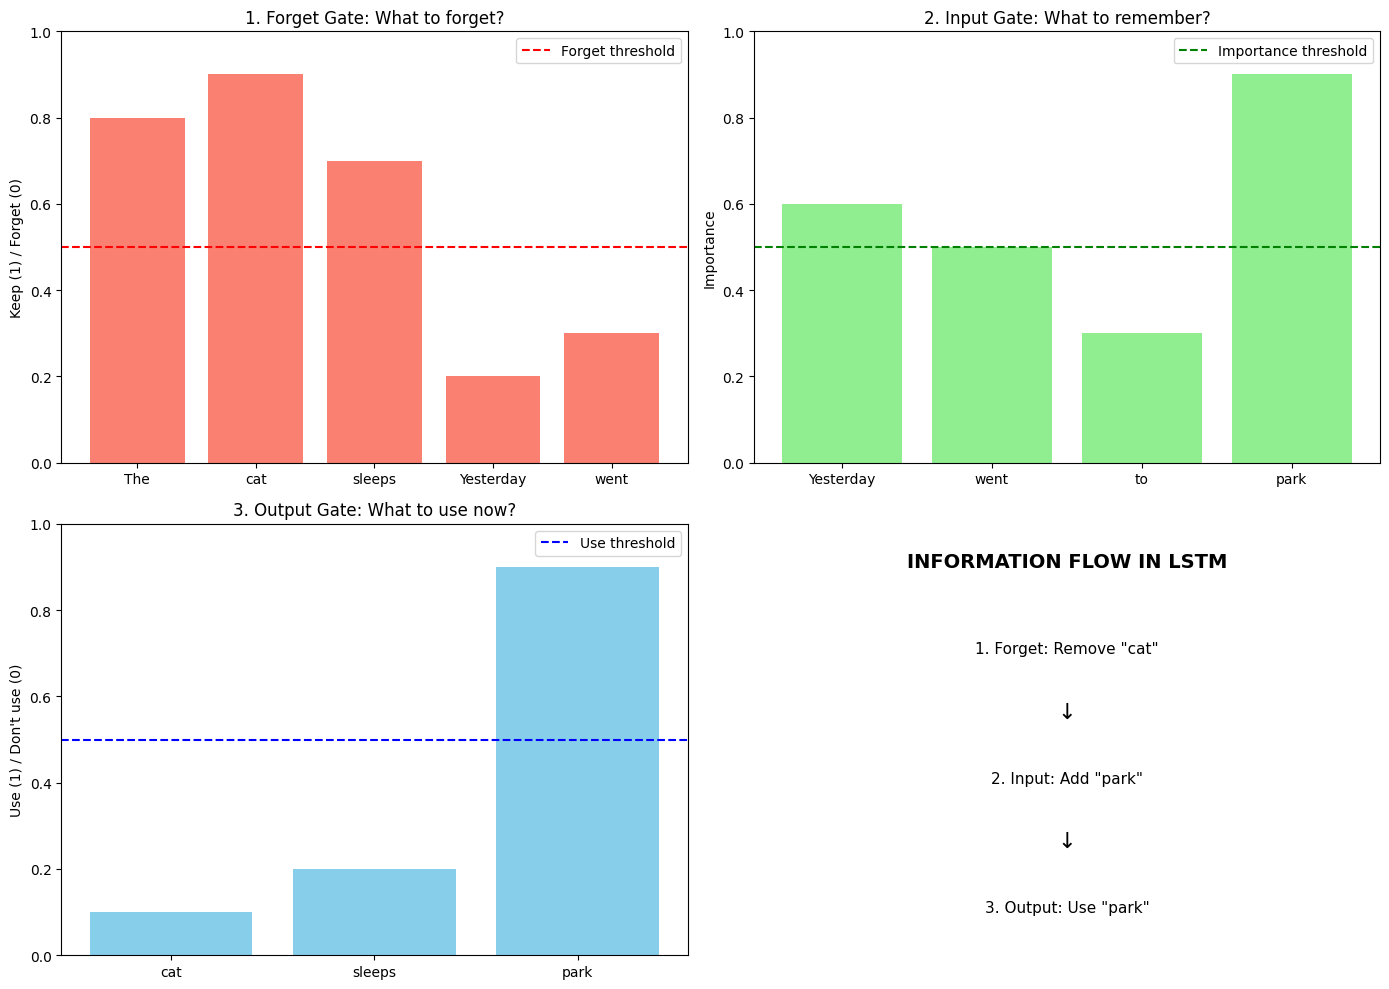

In [2]:
def explain_lstm_gates():
    """
    Explains the three gates that make LSTM special.
    """
    print("\n" + "=" * 60)
    print("LSTM ARCHITECTURE: THE THREE GATES")
    print("=" * 60)

    print(
        """
    An LSTM has three "gates" that control the flow of information:

    1. FORGET GATE:
       Determines what information from the past should be discarded.

       Example: "The cat was... Yesterday I went to the park..."
       → Forget "cat" because we changed topics

    2. INPUT GATE:
       Determines what new information should be stored.

       Example: "Yesterday I went to the park..."
       → Remember "park" because it's the new important topic

    3. OUTPUT GATE:
       Determines what information should be used in the current step.

       Example: "In the park I saw ___"
       → Use information from "park" to predict next word
    """
    )

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    ax1 = axes[0, 0]
    sequence = ["The", "cat", "sleeps", "Yesterday", "went"]
    importance = [0.8, 0.9, 0.7, 0.2, 0.3]
    ax1.bar(sequence, importance, color="salmon")
    ax1.axhline(y=0.5, color="red", linestyle="--", label="Forget threshold")
    ax1.set_ylabel("Keep (1) / Forget (0)")
    ax1.set_title("1. Forget Gate: What to forget?")
    ax1.legend()
    ax1.set_ylim(0, 1)

    ax2 = axes[0, 1]
    new_words = ["Yesterday", "went", "to", "park"]
    relevance = [0.6, 0.5, 0.3, 0.9]
    ax2.bar(new_words, relevance, color="lightgreen")
    ax2.axhline(y=0.5, color="green", linestyle="--", label="Importance threshold")
    ax2.set_ylabel("Importance")
    ax2.set_title("2. Input Gate: What to remember?")
    ax2.legend()
    ax2.set_ylim(0, 1)

    ax3 = axes[1, 0]
    context = ["cat", "sleeps", "park"]
    use = [0.1, 0.2, 0.9]
    ax3.bar(context, use, color="skyblue")
    ax3.axhline(y=0.5, color="blue", linestyle="--", label="Use threshold")
    ax3.set_ylabel("Use (1) / Don't use (0)")
    ax3.set_title("3. Output Gate: What to use now?")
    ax3.legend()
    ax3.set_ylim(0, 1)

    ax4 = axes[1, 1]
    ax4.text(
        0.5,
        0.9,
        "INFORMATION FLOW IN LSTM",
        ha="center",
        fontsize=14,
        fontweight="bold",
    )
    ax4.text(0.5, 0.7, '1. Forget: Remove "cat"', ha="center", fontsize=11)
    ax4.text(0.5, 0.55, "↓", ha="center", fontsize=16)
    ax4.text(0.5, 0.4, '2. Input: Add "park"', ha="center", fontsize=11)
    ax4.text(0.5, 0.25, "↓", ha="center", fontsize=16)
    ax4.text(0.5, 0.1, '3. Output: Use "park"', ha="center", fontsize=11)
    ax4.axis("off")

    plt.tight_layout()
    plt.show()


explain_lstm_gates()

## Conceptual implementation of an LSTM

To deeply understand the internal workings of LSTMs, it is instructive to examine a
simplified implementation that explicitly exposes the underlying mathematical operations.
This pedagogical approach allows visualizing how the different gates interact and how the
cell and hidden states are updated at each time step.

The fundamental equations governing the behavior of an LSTM cell can be expressed
mathematically as:

$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$
$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
$$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$
$$C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$$
$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$ $$h_t = o_t \odot \tanh(C_t)$$

where $f_t$, $i_t$ and $o_t$ represent the forget, input and output gates respectively,
$C_t$ denotes the cell state, $h_t$ the hidden state, $\sigma$ the sigmoid function,
$\odot$ the element-wise product (Hadamard), and $W$ and $b$ the corresponding weight
matrices and bias vectors.

In [3]:
class SimpleLSTM:
    """
    Simplified LSTM for educational purposes.
    Shows basic concepts without all the mathematical complexity.
    """

    def __init__(self, input_size=1, hidden_size=3):
        self.hidden_size = hidden_size
        self.C = np.zeros((hidden_size, 1))
        self.h = np.zeros((hidden_size, 1))

        self.W_forget = np.random.randn(hidden_size, input_size + hidden_size) * 0.1
        self.W_input = np.random.randn(hidden_size, input_size + hidden_size) * 0.1
        self.W_output = np.random.randn(hidden_size, input_size + hidden_size) * 0.1
        self.W_candidate = np.random.randn(hidden_size, input_size + hidden_size) * 0.1

        print("Simple LSTM created")
        print(f"  - Input size: {input_size}")
        print(f"  - Hidden size: {hidden_size}")
        print(f"  - Cell state (memory): {self.C.shape}")
        print(f"  - Hidden state (output): {self.h.shape}")

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def tanh(self, x):
        return np.tanh(np.clip(x, -500, 500))

    def step(self, x, verbose=True):
        """
        Processes ONE step with all LSTM gates.
        """
        x = np.array([[x]])
        combined = np.vstack([self.h, x])

        f = self.sigmoid(np.dot(self.W_forget, combined))
        i = self.sigmoid(np.dot(self.W_input, combined))
        C_candidate = self.tanh(np.dot(self.W_candidate, combined))
        self.C = f * self.C + i * C_candidate
        o = self.sigmoid(np.dot(self.W_output, combined))
        self.h = o * self.tanh(self.C)

        if verbose:
            print(f"\n  Forget Gate: {f.flatten()}")
            print(f"  Input Gate: {i.flatten()}")
            print(f"  Output Gate: {o.flatten()}")
            print(f"  Cell State (memory): {self.C.flatten()}")
            print(f"  Hidden State (output): {self.h.flatten()}")

        return self.h.copy(), self.C.copy()

    def process_sequence(self, sequence):
        """Processes a complete sequence."""
        print("\n" + "=" * 60)
        print("PROCESSING SEQUENCE WITH LSTM")
        print("=" * 60)
        print(f"Sequence: {sequence}\n")

        states_h = []
        states_C = []

        for t, x in enumerate(sequence):
            print(f" Step {t + 1}: Input = {x} ")
            h, C = self.step(x, verbose=True)
            states_h.append(h)
            states_C.append(C)

        print("\n" + "=" * 60)
        print("SEQUENCE COMPLETED")
        print("=" * 60)
        print(f"Final memory (Cell State): {self.C.flatten()}")
        print(f"Final output (Hidden State): {self.h.flatten()}")

        return states_h, states_C


print("\n" + "=" * 60)
print("EXAMPLE: LSTM processing sequence")
print("=" * 60)

lstm = SimpleLSTM(input_size=1, hidden_size=3)
sequence = [1.0, 2.0, 3.0, 4.0, 5.0]
states_h, states_C = lstm.process_sequence(sequence)


EXAMPLE: LSTM processing sequence
Simple LSTM created
  - Input size: 1
  - Hidden size: 3
  - Cell state (memory): (3, 1)
  - Hidden state (output): (3, 1)

PROCESSING SEQUENCE WITH LSTM
Sequence: [1.0, 2.0, 3.0, 4.0, 5.0]

 Step 1: Input = 1.0 

  Forget Gate: [0.51723974 0.4963512  0.5167667 ]
  Input Gate: [0.51469707 0.48713857 0.50925154]
  Output Gate: [0.44961008 0.48864278 0.51408744]
  Cell State (memory): [0.00567707 0.02366618 0.00290134]
  Hidden State (output): [0.00255244 0.01156215 0.00149154]
 Step 2: Input = 2.0 

  Forget Gate: [0.53486739 0.49295371 0.53338988]
  Input Gate: [0.52971395 0.47415585 0.51855983]
  Output Gate: [0.40005979 0.47692127 0.52861977]
  Cell State (memory): [0.0141069  0.05832318 0.00730352]
  Hidden State (output): [0.00564323 0.02778407 0.00386072]
 Step 3: Input = 3.0 

  Forget Gate: [0.55256031 0.48967277 0.54989315]
  Input Gate: [0.54481188 0.4611822  0.52787081]
  Output Gate: [0.35239107 0.46508844 0.5432562 ]
  Cell State (memory):

## Visualization of state evolution

Understanding the dynamic behavior of LSTMs is facilitated by simultaneously visualizing
the evolution of the cell state and hidden state throughout the processing of a sequence.
While the hidden state tends to fluctuate rapidly in response to each new input,
reflecting information relevant to the current step, the cell state exhibits more gradual
changes, accumulating information persistently across multiple time steps. This
fundamental difference in the dynamics of both states constitutes the key to LSTM success
in handling long-term dependencies.

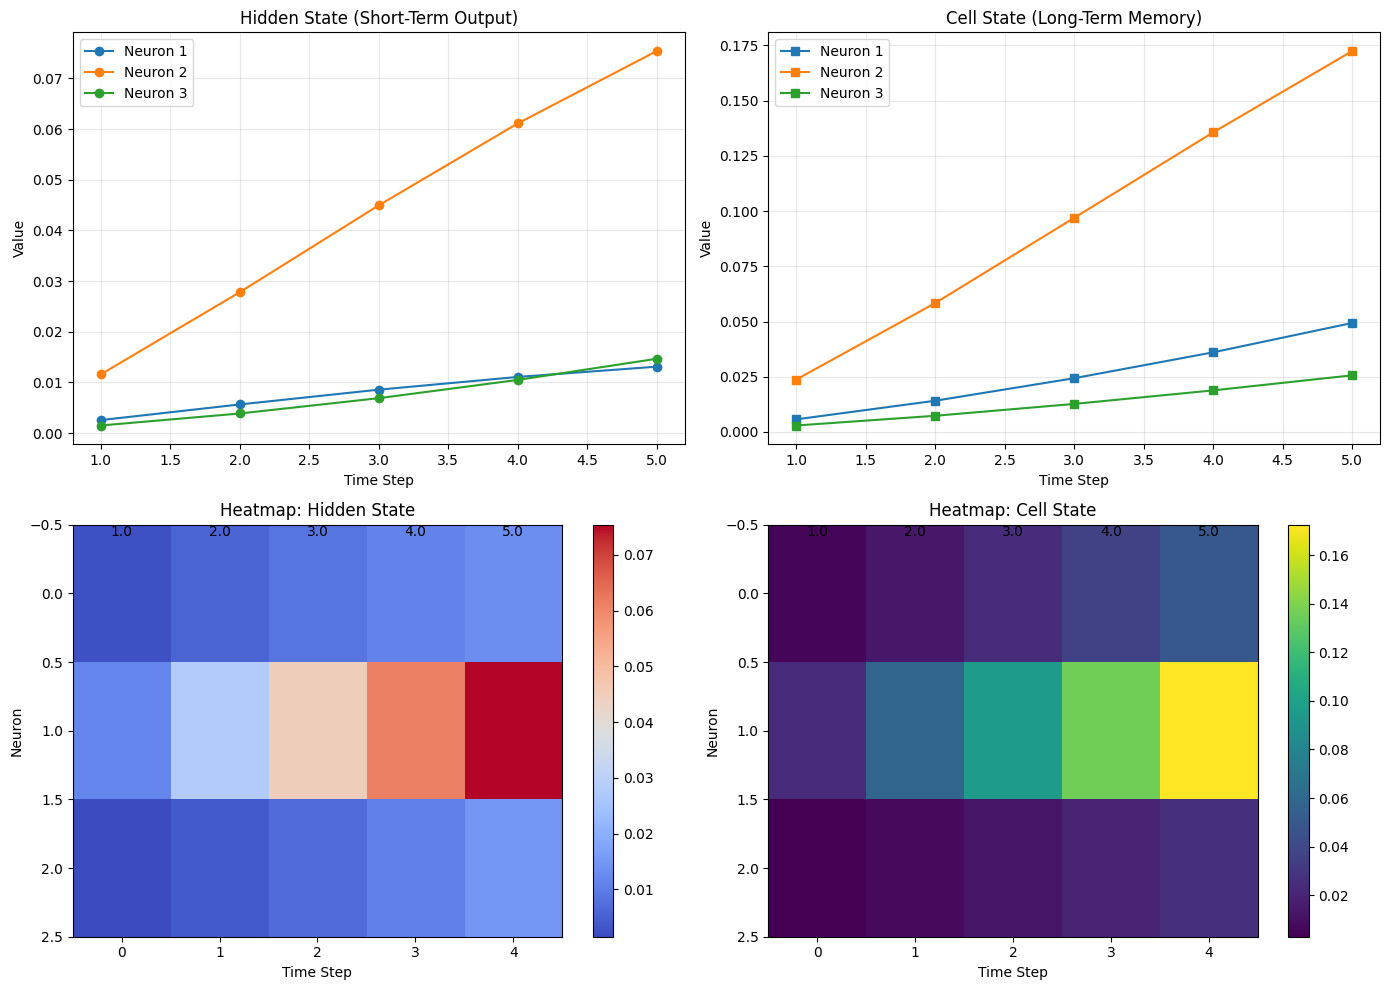


INTERPRETATION:
------------------------------------------------------------
1. Hidden State (top left):
   - Changes rapidly with each new input
   - Represents immediate output

2. Cell State (top right):
   - Changes more smoothly
   - Accumulates information over time
   - Is the true 'memory' of the LSTM


In [4]:
def visualize_gates_in_action(states_h, states_C, sequence):
    """
    Visualizes how LSTM states evolve.
    """
    h_array = np.array([h.flatten() for h in states_h])
    C_array = np.array([C.flatten() for C in states_C])

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    ax1 = axes[0, 0]
    for i in range(h_array.shape[1]):
        ax1.plot(
            range(1, len(sequence) + 1),
            h_array[:, i],
            marker="o",
            label=f"Neuron {i+1}",
        )
    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("Value")
    ax1.set_title("Hidden State (Short-Term Output)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2 = axes[0, 1]
    for i in range(C_array.shape[1]):
        ax2.plot(
            range(1, len(sequence) + 1),
            C_array[:, i],
            marker="s",
            label=f"Neuron {i+1}",
        )
    ax2.set_xlabel("Time Step")
    ax2.set_ylabel("Value")
    ax2.set_title("Cell State (Long-Term Memory)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax3 = axes[1, 0]
    im1 = ax3.imshow(h_array.T, aspect="auto", cmap="coolwarm", interpolation="nearest")
    ax3.set_xlabel("Time Step")
    ax3.set_ylabel("Neuron")
    ax3.set_title("Heatmap: Hidden State")
    plt.colorbar(im1, ax=ax3)

    for i, val in enumerate(sequence):
        ax3.text(i, -0.5, f"{val}", ha="center", va="top")

    ax4 = axes[1, 1]
    im2 = ax4.imshow(C_array.T, aspect="auto", cmap="viridis", interpolation="nearest")
    ax4.set_xlabel("Time Step")
    ax4.set_ylabel("Neuron")
    ax4.set_title("Heatmap: Cell State")
    plt.colorbar(im2, ax=ax4)

    for i, val in enumerate(sequence):
        ax4.text(i, -0.5, f"{val}", ha="center", va="top")

    plt.tight_layout()
    plt.show()

    print("\nINTERPRETATION:")
    print("-" * 60)
    print("1. Hidden State (top left):")
    print("   - Changes rapidly with each new input")
    print("   - Represents immediate output")
    print("\n2. Cell State (top right):")
    print("   - Changes more smoothly")
    print("   - Accumulates information over time")
    print("   - Is the true 'memory' of the LSTM")


visualize_gates_in_action(states_h, states_C, sequence)

## Implementation with PyTorch and empirical comparison

While manual implementations provide deep understanding of internal mechanisms, in
professional practice optimized frameworks are used that encapsulate computational
complexity. PyTorch offers highly efficient LSTM modules that automatically handle
aspects such as gradient calculation through backpropagation through time, weight
initialization, and GPU acceleration.

To empirically demonstrate the superiority of LSTMs over simple RNNs in tasks requiring
long-term memory, it is instructive to design a controlled experiment where the objective
explicitly depends on information presented at the beginning of the sequence. This
configuration allows directly evaluating the ability of each architecture to maintain and
use information across multiple time steps.


COMPARISON: RNN vs LSTM

Task: Predict if the FIRST number is even/odd
Example sequences:
  [3. 2. 4. 9. 0. 5. 2. 7. 4. 7.] -> First element: 3 -> ODD
  [2. 8. 1. 8. 6. 5. 0. 2. 4. 2.] -> First element: 2 -> EVEN
  [4. 8. 0. 2. 0. 5. 9. 4. 5. 6.] -> First element: 4 -> EVEN

------------------------------------------------------------
Training Simple RNN...
------------------------------------------------------------

------------------------------------------------------------
Training LSTM...
------------------------------------------------------------


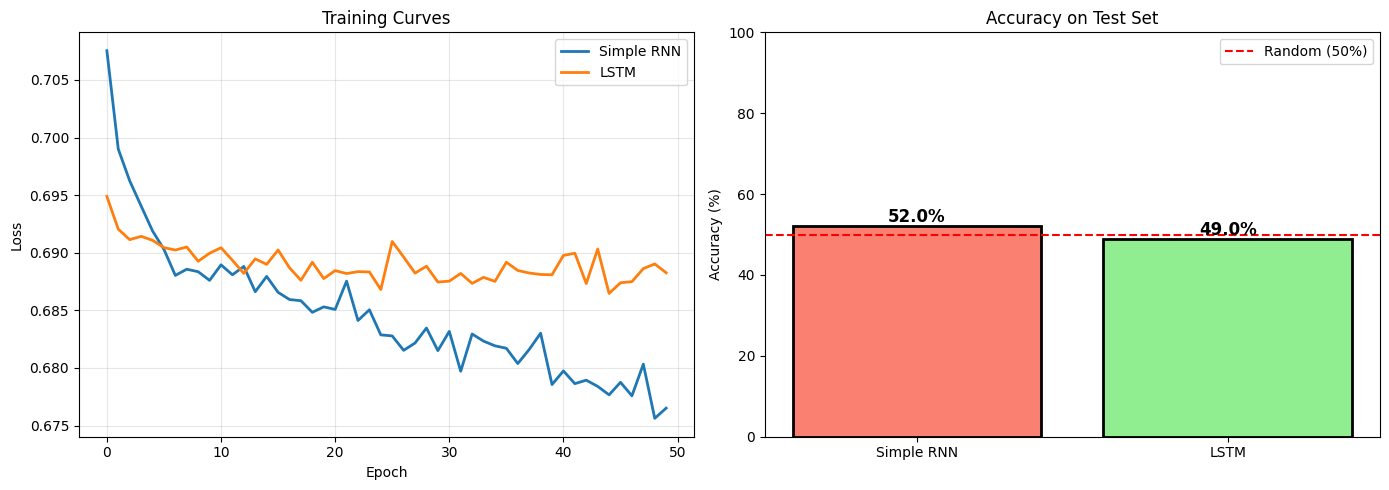


RESULTS
Simple RNN - Accuracy: 52.00%
LSTM       - Accuracy: 49.00%

Why is LSTM better?
- Maintains memory of the FIRST element of the sequence
- Gates protect important information
- Simple RNN forgets early information


In [5]:
class LSTMPyTorch(nn.Module):
    """
    Professional LSTM using PyTorch.
    """

    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMPyTorch, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0,
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass.

        Args:
            x: Tensor of shape (batch, sequence, features)

        Returns:
            prediction: Tensor of shape (batch, output_size)
        """
        output, (h_n, c_n) = self.lstm(x)
        last_output = output[:, -1, :]
        prediction = self.fc(last_output)
        return prediction


def compare_rnn_vs_lstm():
    """
    Compares simple RNN vs LSTM on a real task.
    """
    print("\n" + "=" * 60)
    print("COMPARISON: RNN vs LSTM")
    print("=" * 60)

    def create_memory_sequences(num_examples=500):
        """
        Creates sequences where the target depends on the FIRST element.
        Example: [5, 2, 3, 8, 1, 9] -> Predict if first number (5) is even/odd
        """
        X = []
        y = []

        for _ in range(num_examples):
            sequence = np.random.randint(0, 10, size=10)
            first_element = sequence[0]
            is_even = 1 if first_element % 2 == 0 else 0
            X.append(sequence)
            y.append(is_even)

        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

    X, y = create_memory_sequences(500)

    print(f"\nTask: Predict if the FIRST number is even/odd")
    print(f"Example sequences:")
    for i in range(3):
        result = "EVEN" if y[i] == 1 else "ODD"
        print(f"  {X[i]} -> First element: {int(X[i][0])} -> {result}")

    X_tensor = torch.FloatTensor(X).unsqueeze(-1)
    y_tensor = torch.FloatTensor(y).unsqueeze(-1)

    split = int(0.8 * len(X))
    X_train, X_test = X_tensor[:split], X_tensor[split:]
    y_train, y_test = y_tensor[:split], y_tensor[split:]

    from torch.utils.data import TensorDataset, DataLoader

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    class SimpleRNN(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(SimpleRNN, self).__init__()
            self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            output, h_n = self.rnn(x)
            out = self.fc(output[:, -1, :])
            return self.sigmoid(out)

    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            output, (h_n, c_n) = self.lstm(x)
            out = self.fc(output[:, -1, :])
            return self.sigmoid(out)

    def train_model(model, train_loader, epochs=50):
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        history = []

        for epoch in range(epochs):
            epoch_loss = 0
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            history.append(epoch_loss / len(train_loader))

        return history

    print("\n" + "-" * 60)
    print("Training Simple RNN...")
    print("-" * 60)
    rnn = SimpleRNN(1, 20, 1)
    hist_rnn = train_model(rnn, train_loader, epochs=50)

    print("\n" + "-" * 60)
    print("Training LSTM...")
    print("-" * 60)
    lstm = LSTMModel(1, 20, 1)
    hist_lstm = train_model(lstm, train_loader, epochs=50)

    def evaluate(model, X, y):
        model.eval()
        with torch.no_grad():
            predictions = model(X)
            binary_predictions = (predictions > 0.5).float()
            accuracy = (binary_predictions == y).float().mean()
        return accuracy.item()

    accuracy_rnn = evaluate(rnn, X_test, y_test)
    accuracy_lstm = evaluate(lstm, X_test, y_test)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(hist_rnn, label="Simple RNN", linewidth=2)
    axes[0].plot(hist_lstm, label="LSTM", linewidth=2)
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training Curves")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    models = ["Simple RNN", "LSTM"]
    accuracies = [accuracy_rnn * 100, accuracy_lstm * 100]
    colors = ["salmon", "lightgreen"]

    bars = axes[1].bar(models, accuracies, color=colors, edgecolor="black", linewidth=2)
    axes[1].set_ylabel("Accuracy (%)")
    axes[1].set_title("Accuracy on Test Set")
    axes[1].set_ylim(0, 100)
    axes[1].axhline(y=50, color="red", linestyle="--", label="Random (50%)")
    axes[1].legend()

    for bar, accuracy in zip(bars, accuracies):
        height = bar.get_height()
        axes[1].text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{accuracy:.1f}%",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight="bold",
        )

    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print("RESULTS")
    print("=" * 60)
    print(f"Simple RNN - Accuracy: {accuracy_rnn*100:.2f}%")
    print(f"LSTM       - Accuracy: {accuracy_lstm*100:.2f}%")
    print("\nWhy is LSTM better?")
    print("- Maintains memory of the FIRST element of the sequence")
    print("- Gates protect important information")
    print("- Simple RNN forgets early information")


compare_rnn_vs_lstm()

## Application to time series prediction

Time series prediction constitutes one of the most relevant applications of LSTMs in
industrial and scientific contexts. Time series, characterized by chronologically ordered
sequential observations, frequently present complex patterns that include long-term
trends, periodic seasonal components, and stochastic fluctuations. LSTMs are particularly
suitable for this type of data due to their ability to capture temporal dependencies at
multiple scales.

In this context, the objective consists of using a window of historical observations to
predict future values. The LSTM architecture processes the input sequence, extracting
relevant patterns and encoding them in its internal state, to subsequently generate
predictions over the desired time horizon. This approach allows performing multi-step
predictions, where multiple future values are estimated simultaneously.


PROJECT: Time Series Prediction with LSTM


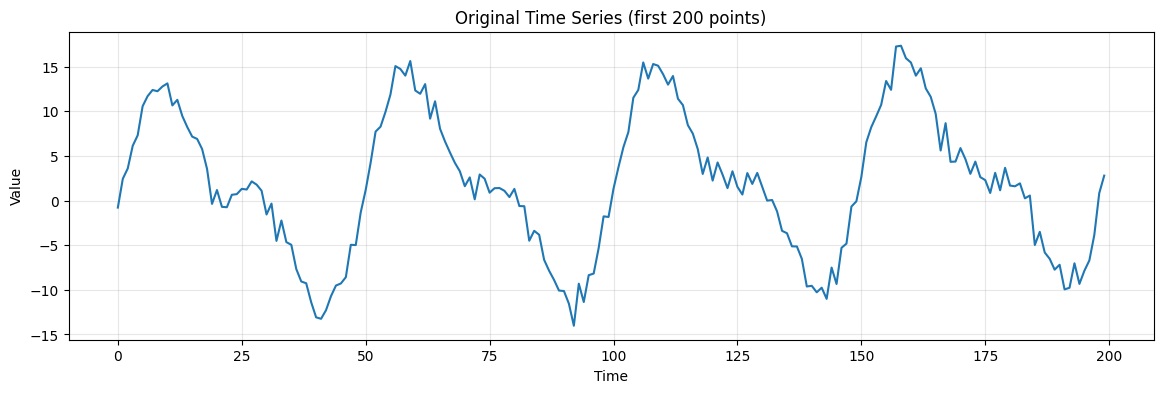


Series generated: 1000 points
Minimum: -14.02, Maximum: 34.18

Sequences created:
  X shape: (941, 50) (samples, sequence_length)
  y shape: (941, 10) (samples, horizon)

Training data: 752 sequences
Test data: 189 sequences

LSTM Model:
LSTMPredictor(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

Training LSTM...
Epoch 10/50 - Train Loss: 0.013391, Test Loss: 0.011512
Epoch 20/50 - Train Loss: 0.004746, Test Loss: 0.010938
Epoch 30/50 - Train Loss: 0.001989, Test Loss: 0.005055
Epoch 40/50 - Train Loss: 0.001513, Test Loss: 0.003897
Epoch 50/50 - Train Loss: 0.001083, Test Loss: 0.002009


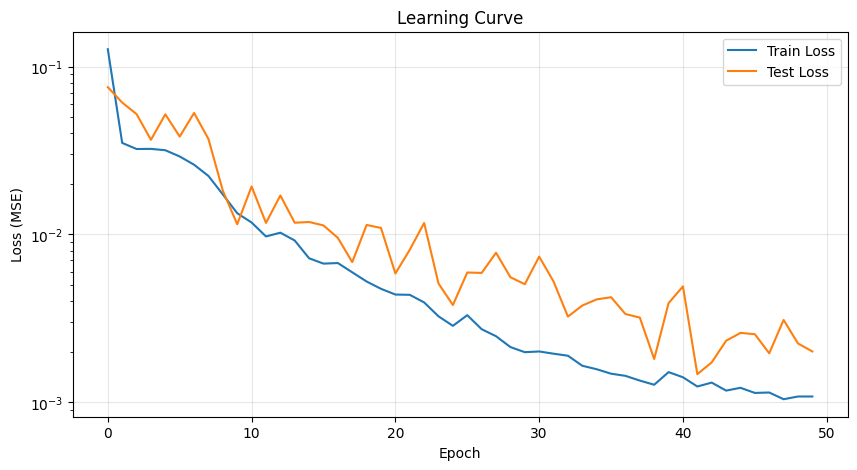

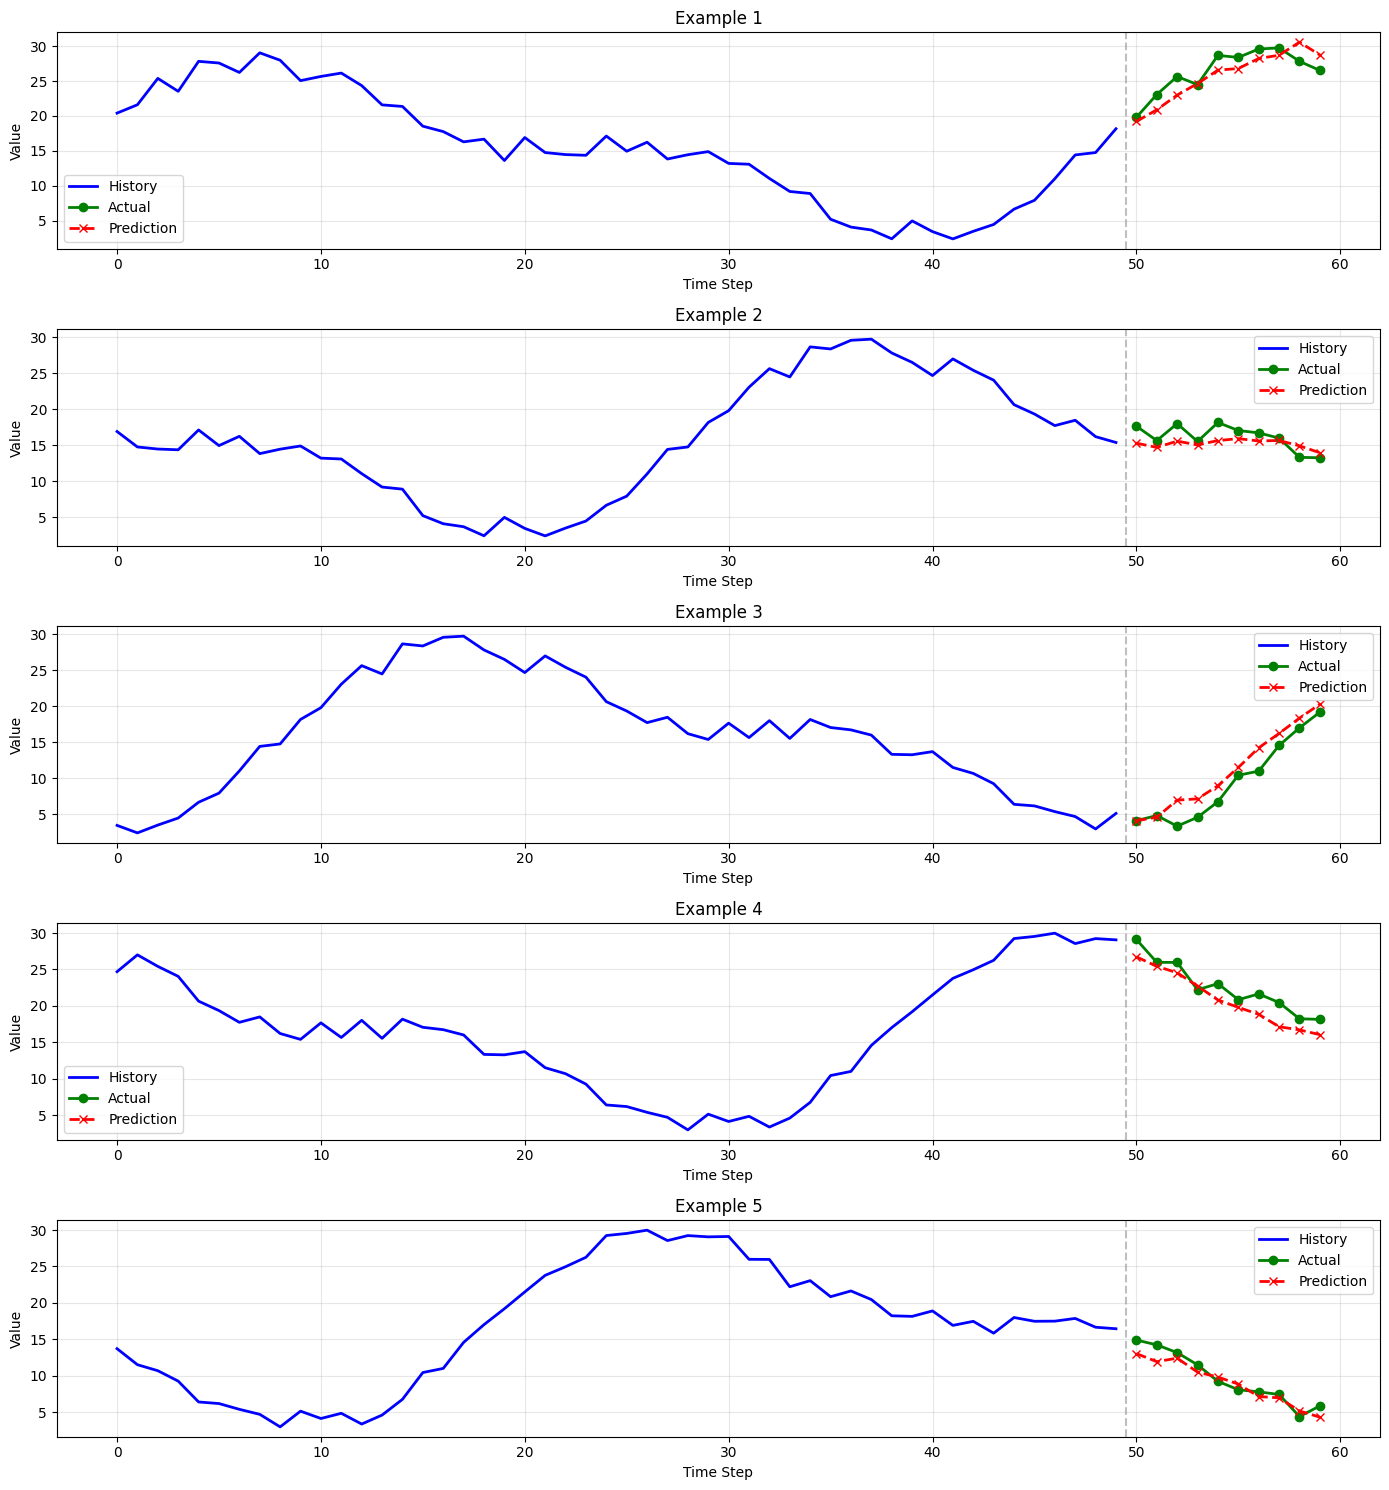


FINAL RESULTS
MAE (Mean Absolute Error): 1.7175
RMSE (Root Mean Squared Error): 2.1601

The model can predict 10 steps into the future
based on the last 50 observed values.


In [7]:
from torch.utils.data import TensorDataset, DataLoader


def time_series_lstm_project():
    """
    Complete project: Time series predictor with LSTM.
    """
    print("\n" + "=" * 60)
    print("PROJECT: Time Series Prediction with LSTM")
    print("=" * 60)

    def generate_time_series(n=1000):
        """
        Generates a time series with multiple components:
        - Trend
        - Seasonality
        - Noise
        """
        t = np.arange(n)
        trend = 0.02 * t
        seasonal = 10 * np.sin(2 * np.pi * t / 50) + 5 * np.sin(2 * np.pi * t / 25)
        noise = np.random.normal(0, 1, n)
        series = trend + seasonal + noise
        return series, t

    series, time = generate_time_series(1000)

    plt.figure(figsize=(14, 4))
    plt.plot(time[:200], series[:200])
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title("Original Time Series (first 200 points)")
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"\nSeries generated: {len(series)} points")
    print(f"Minimum: {series.min():.2f}, Maximum: {series.max():.2f}")

    def create_sequences(series, sequence_length=50, horizon=1):
        """
        Converts series into sequences for training.

        Args:
            series: Time series
            sequence_length: How many steps to look back
            horizon: How many steps to predict forward
        """
        X, y = [], []

        for i in range(len(series) - sequence_length - horizon + 1):
            X.append(series[i : i + sequence_length])
            y.append(series[i + sequence_length : i + sequence_length + horizon])

        return np.array(X), np.array(y)

    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler()
    series_norm = scaler.fit_transform(series.reshape(-1, 1)).flatten()

    SEQ_LENGTH = 50
    HORIZON = 10

    X, y = create_sequences(series_norm, SEQ_LENGTH, HORIZON)

    print(f"\nSequences created:")
    print(f"  X shape: {X.shape} (samples, sequence_length)")
    print(f"  y shape: {y.shape} (samples, horizon)")

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    X_train_t = torch.FloatTensor(X_train).unsqueeze(-1)
    y_train_t = torch.FloatTensor(y_train)
    X_test_t = torch.FloatTensor(X_test).unsqueeze(-1)
    y_test_t = torch.FloatTensor(y_test)

    print(f"\nTraining data: {len(X_train)} sequences")
    print(f"Test data: {len(X_test)} sequences")

    class LSTMPredictor(nn.Module):
        def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=10):
            super(LSTMPredictor, self).__init__()
            self.lstm = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=0.2,
            )
            self.fc = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            lstm_out, (h_n, c_n) = self.lstm(x)
            last_output = lstm_out[:, -1, :]
            prediction = self.fc(last_output)
            return prediction

    model = LSTMPredictor(
        input_size=1, hidden_size=64, num_layers=2, output_size=HORIZON
    )

    print(f"\nLSTM Model:")
    print(model)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    print("\nTraining LSTM...")
    train_history = []
    test_history = []
    EPOCHS = 50

    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_history.append(avg_train_loss)

        model.eval()
        with torch.no_grad():
            pred_test = model(X_test_t)
            test_loss = criterion(pred_test, y_test_t).item()
            test_history.append(test_loss)

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.6f}, Test Loss: {test_loss:.6f}"
            )

    plt.figure(figsize=(10, 5))
    plt.plot(train_history, label="Train Loss")
    plt.plot(test_history, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale("log")
    plt.show()

    model.eval()
    with torch.no_grad():
        predictions = model(X_test_t).numpy()

    predictions_orig = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(
        predictions.shape
    )
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

    n_examples = 5
    fig, axes = plt.subplots(n_examples, 1, figsize=(14, 3 * n_examples))

    for i in range(n_examples):
        idx = i * 20
        input_data = scaler.inverse_transform(X_test[idx].reshape(-1, 1)).flatten()

        axes[i].plot(
            range(len(input_data)), input_data, "b-", label="History", linewidth=2
        )
        axes[i].plot(
            range(len(input_data), len(input_data) + HORIZON),
            y_test_orig[idx],
            "g-",
            marker="o",
            label="Actual",
            linewidth=2,
        )
        axes[i].plot(
            range(len(input_data), len(input_data) + HORIZON),
            predictions_orig[idx],
            "r--",
            marker="x",
            label="Prediction",
            linewidth=2,
        )

        axes[i].axvline(
            x=len(input_data) - 0.5, color="gray", linestyle="--", alpha=0.5
        )
        axes[i].set_xlabel("Time Step")
        axes[i].set_ylabel("Value")
        axes[i].set_title(f"Example {i+1}")
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    mae = np.mean(np.abs(y_test_orig - predictions_orig))
    rmse = np.sqrt(np.mean((y_test_orig - predictions_orig) ** 2))

    print("\n" + "=" * 60)
    print("FINAL RESULTS")
    print("=" * 60)
    print(f"MAE (Mean Absolute Error): {mae:.4f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"\nThe model can predict {HORIZON} steps into the future")
    print(f"based on the last {SEQ_LENGTH} observed values.")


time_series_lstm_project()